# Importing Necessary Packages

In [1338]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.mosaicplot import mosaic
from IPython.display import Image
from IPython.core.display import HTML 
import sklearn as sk
import sklearn.cluster as skc
import sklearn.decomposition as skd
import sklearn.metrics as skm
import sklearn.manifold as skma
import sklearn.preprocessing as skp
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn.metrics as skmetric
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import sklearn.tree as sktree
import sklearn.externals.six as sksix
import pydot_ng as pydot
import IPython.display as ipd
import sklearn.ensemble as skens

## Data Loading/Cleaning 

The incoming dataset can be found at: http://www.sports-reference.com/cbb/seasons/2017-school-stats.html. 

Below I have created df_new. In df_new, Team Name is now the index. I have also dropped columns that will not be needed for my analysis to make the Data Frame more manageable. I have changed column names to names that are more intuitative.  Additionally I have transformed individual values from strings to floats to enable calculations.

In [1339]:
df = pd.DataFrame.from_csv('NCAA.txt')  #CSV file from SportsRefernce
df_i = df.set_index([df['Unnamed: 1']])
df_i.drop(df_i.columns[7:13], axis=1, inplace=True)
df_i = df_i.drop('Unnamed: 1', axis=1)
df_i = df_i.drop('Unnamed: 16', axis=1)
df_i =df_i.drop('School Totals',axis=1)
df_new = pd.DataFrame(df_i.ix[1:] )
df_new.columns = df_i.ix[0]
df_new = df_new.rename(index=str, columns={"Tm.": "Total Points", "Opp.": "Opponent Points","W▼":"W"})
df_new.columns
df_new[df_new.columns] = df_new[df_new.columns].apply(pd.to_numeric)

Below I am transfroming In-Game Statistics to a per game basis. From the CSV, these values were season totals and different teams play different amounts of games. To normailize for games played, I divided each of these totals by the the number of games played.

CAUTION: ONLY RUN THIS CELL ONCE

In [1340]:
transform =[]    
for c in df_new.columns[6:]:
    if c[-1]!='%':
        transform.append(c)

#per_game = pd.DataFrame(df_new)
for t in transform:
    df_new[t] = df_new[t]/df_new['G']
df_new.head()

School,G,W,L,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,...,FT,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF
Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
Gonzaga *,37,36,1,0.973,25.57,3.25,83.243243,60.918919,29.729730,58.405405,...,16.513514,23.000000,0.718,9.513514,40.459459,15.378378,7.027027,4.594595,11.378378,16.675676
Oregon *,38,33,5,0.868,20.71,7.93,78.947368,65.473684,28.131579,58.210526,...,14.078947,19.973684,0.705,10.368421,36.526316,15.973684,6.526316,6.342105,11.526316,15.631579
Arizona *,37,32,5,0.865,18.25,7.63,76.567568,65.945946,26.405405,55.351351,...,17.162162,22.432432,0.765,10.243243,36.702703,13.540541,5.432432,3.216216,11.189189,16.891892
Kentucky *,38,32,6,0.842,23.88,10.49,84.868421,71.473684,29.842105,63.052632,...,18.157895,25.789474,0.704,12.131579,39.789474,15.394737,6.026316,5.263158,11.657895,18.842105
Villanova *,36,32,4,0.889,23.81,9.29,77.194444,62.666667,26.805556,54.111111,...,14.944444,18.916667,0.790,8.666667,33.555556,14.027778,7.194444,3.027778,11.166667,14.305556


We can see that this dataframe has 351 rows and 24 columns

In [1341]:
df_new.shape

(351, 24)

Creating a new binary column, ['Qualify'] which features:
0 of the team did not Qualify for the NCAA tournament 
1 if the team did qualify for the NCAA tournament. The incoming dataset featured a * if the team qualified. I used this to determine which rows were assigned and which ones were assigned a 0.


In [1342]:
list2= []
for d in df_i.index:
    for l in d:
        list1= []
        list1.append(l)
        if list1[-1]=='*':
            list2.append(d)
df_new['Qualify'] = 0
for x in df_new.index[:]:
    if x in list2:
        df_new.set_value(x, 'Qualify', 1)
df_new.head(5)


School,G,W,L,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,...,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Qualify
Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
Gonzaga *,37,36,1,0.973,25.57,3.25,83.243243,60.918919,29.729730,58.405405,...,23.000000,0.718,9.513514,40.459459,15.378378,7.027027,4.594595,11.378378,16.675676,1
Oregon *,38,33,5,0.868,20.71,7.93,78.947368,65.473684,28.131579,58.210526,...,19.973684,0.705,10.368421,36.526316,15.973684,6.526316,6.342105,11.526316,15.631579,1
Arizona *,37,32,5,0.865,18.25,7.63,76.567568,65.945946,26.405405,55.351351,...,22.432432,0.765,10.243243,36.702703,13.540541,5.432432,3.216216,11.189189,16.891892,1
Kentucky *,38,32,6,0.842,23.88,10.49,84.868421,71.473684,29.842105,63.052632,...,25.789474,0.704,12.131579,39.789474,15.394737,6.026316,5.263158,11.657895,18.842105,1
Villanova *,36,32,4,0.889,23.81,9.29,77.194444,62.666667,26.805556,54.111111,...,18.916667,0.790,8.666667,33.555556,14.027778,7.194444,3.027778,11.166667,14.305556,1


### Generating Summary Statistics

In order to gain an understanding of the dataset, i have used the statsCalculator function to generate summary statistics for columns in the DataFrame.

In [1343]:
def statsCalculator(df_new):
    statsDF = pd.DataFrame()
    
    for c in df_new.columns[:]:
        currentSeries = df_new[c]
        
        seriesMean = np.mean(currentSeries)
        seriesMedian = np.median(currentSeries)
        seriesVariance = np.var(currentSeries)
        seriesStdev = np.std(currentSeries)
        seriesMode = stats.mode(currentSeries)
        
        statsDF[c] = pd.Series([seriesMean, seriesMedian, seriesVariance, seriesStdev, seriesMode],
                                               index=['Mean', 'Median', 'Variance', 'Stdev', 'Mode'])
    
    return statsDF;


statsCalculator(df_new)

,G,W,L,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,...,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Qualify
Mean,32.7664,16.9886,15.7778,0.511575,-0.587436,-0.262564,73.2763,72.3372,25.7117,57.9594,...,20.5202,0.702886,10.3815,35.6697,13.5227,6.20028,3.38849,13.0397,18.8098,0.193732
Median,33,17,16,0.514,-1.55,-1.97,73.3125,72.0811,25.8125,58.0882,...,20.4667,0.701,10.3235,35.75,13.4848,6.10811,3.28125,13.0625,18.8438,0
Variance,4.5779,41.1908,25.831,0.0294244,111.093,34.7039,30.0894,30.0001,3.91536,8.97511,...,6.80872,0.00135444,2.85362,6.34026,3.41639,1.30872,0.956094,1.95423,3.08714,0.1562
Stdev,2.1396,6.418,5.08242,0.171535,10.5401,5.891,5.48538,5.47724,1.97873,2.99585,...,2.60935,0.0368027,1.68927,2.51799,1.84835,1.14399,0.9778,1.39794,1.75702,0.395221
Mode,"([32], [84])","([20], [28])","([16], [34])","([0.5], [16])","([-10.99], [2])","([-4.2], [3])","([77.0], [4])","([74.5], [3])","([25.0], [3])","([58.7575757576], [3])",...,"([19.5], [3])","([0.683], [9])","([10.0], [7])","([34.625], [3])","([15.0], [4])","([5.65625], [5])","([4.0], [5])","([11.7575757576], [3])","([17.5625], [4])","([0], [283])"


## Research Question #1: Which in-game statistic is the best predictor of team wins?

### Technique: Distributional analyses for Normality of Wins/Qualify (1)

Running the multiplePlots function to generate a Histogram, Lag Plot, QQ-plot and run sequence plot for the win (W) variable.

/Applications/anaconda/envs/si370/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


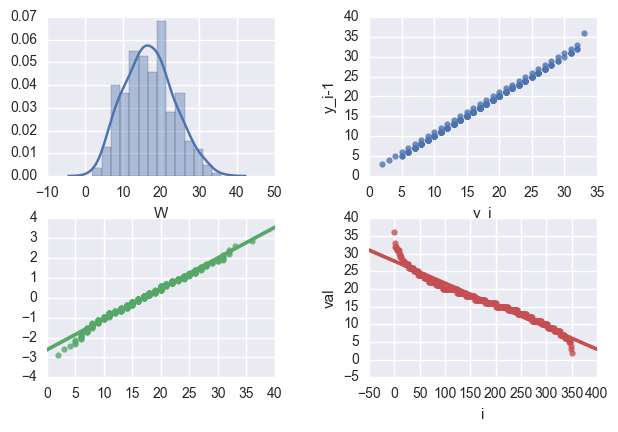

In [1344]:
def multiplePlots( series ):
    
    fig, axs = plt.subplots(2,2)
    plt.tight_layout(pad=0.4, w_pad=4, h_pad=1.0)

    # Histogram
    sns.distplot(series, ax=axs[0,0])
    
    # Lag plot
    lag = series.copy()
    lag = np.array(lag[:-1])
    current = series[1:]
    ax = sns.regplot(current,lag,fit_reg=False, ax=axs[0,1])
    ax.set_ylabel("y_i-1")
    ax.set_xlabel("y_i")
    
    # QQ plot
    qntls, xr = stats.probplot(series, fit=False)
    sns.regplot(xr,qntls, ax=axs[1,0])
    
    # Run sequence
    ax = sns.regplot(np.arange(len(series)),series, ax=axs[1,1])
    ax.set_ylabel("val")
    ax.set_xlabel("i")

multiplePlots(df_new['W'])

4-Plot Results for wins:
    
    1)Histogram: The distribution of wins appears to be randomly distributed.
    
    2)Lag Plot: We observe a clear linear trend in the data, this is worrisome; as it indicates one  observation may depend on the previous observation.   
    
    3) QQ-Plot: We would expect to see data that closely follows a straight line, this is represented in the output. This supports that wins are normally distributed.
    
    4) Run Sequence: We would expect to see random variation around the mean. However there once again appears to be a strong linear trend. 
    
Why is Randomness not met?  
    The condition of random samples appears to be violated in the Lag Plot and Run Sequence Plot. This makes sense because the CSV that was inported was sorted based on wins. Therefore in the incoming dataset there did appear to be clear trends in Wins as the incoming dataset based on this value.  


 In order to overcome the lack of Random Sampling, I will randomly resample my data. 

/Applications/anaconda/envs/si370/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


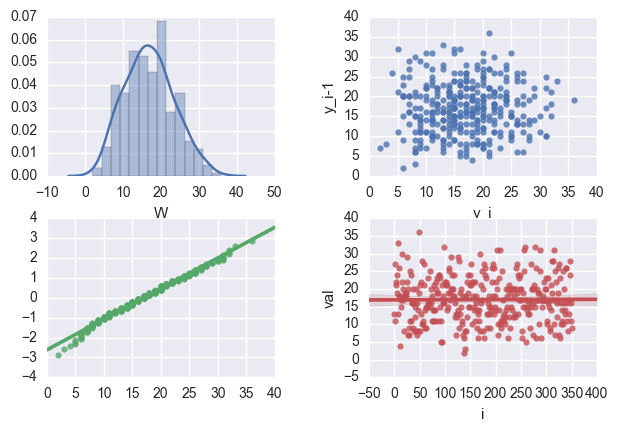

In [1345]:
df_new = df_new.sample(frac=1)
multiplePlots(df_new['W'])

4-Plot Results for wins:
    
    1)Histogram: The distribution of wins appears to be randomly distributed.
    
    2)Lag Plot: We observe no clear linear trend in the data, this is the ideal outcome; as it indicates one  observation is independant of the previous observation.   
    
    3) QQ-Plot: We would expect to see data that closely follows a straight line, this is represented in the output. This supports that wins are normally distributed.
    
     4) Run Sequence: There appears to random variation of equal width around the mean throught all index values. This is an ideal outcome as it indicates the observations are random. 
     
     
 Conclusion: After randomizing the order of my dataset, it appears that all conditions have been met to run a regression with Wins as the Outocome Variable.

### Technique: Correlation analysis (Win and In-Game Statistics) (2)

Because I discovered, the distribution of Wins is approximately normal I chosen to use the Pearson correlation. This is the the default method for the .corr() method, therefore I will not specify the method going forward when using the .corr() method 

In [883]:
df_new.corr()['W'].sort_values(ascending =False)
sub_pos = df_new.corr()['W'].sort_values(ascending= False)[:10]
sub_neg = df_new.corr()['W'].sort_values()[:]
sub_pos


School
W               1.000000
W-L%            0.987711
SRS             0.772142
G               0.725959
Qualify         0.642211
FG%             0.637325
Total Points    0.518521
FG              0.502317
AST             0.475353
3P%             0.426498
Name: W, dtype: float64

After filtering for only in-game statisitcs I created a Data Frame featuring the 3 in-game statistics that have the greatest correlation with 'W'. These statisitcs include: 'Total Points','FG%','Opponent Points'. Additionally I have multiplied FG% by 100 to get it on a whole number scale.

In [1346]:
df_cut = df_new.filter(['W','Total Points','FG%','Opponent Points'], axis=1)
df_cut = df_cut.rename(index=str, columns={"Total Points": "Points", "FG%": "FGP","Opponent Points":"O_Points","3P%":"3_P"})
df_cut['FGP'] = df_cut['FGP'] * 100
df_cut.columns

Index(['W', 'Points', 'FGP', 'O_Points'], dtype='object', name='School')

Generating a Correlation Heat Map

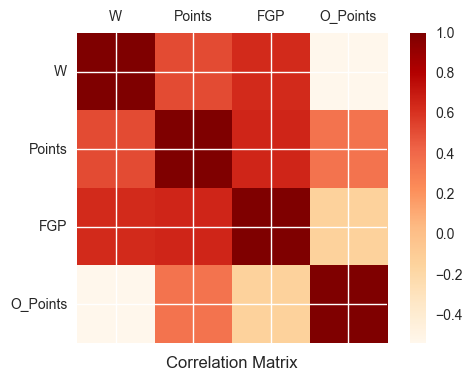

In [1348]:
corr_matrix = df_cut.corr()
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(corr_matrix, cmap=plt.cm.OrRd)
fig.colorbar(cax)

tags = ['']+corr_matrix.columns.tolist()
ax.set_xticklabels(tags)
ax.set_yticklabels(tags)
plt.title('Correlation Matrix', y=-0.1)

In [635]:
#sns.pairplot(df_cut);

### Technique: Regrression for predicting wins from in-game statistics (3)

I will use 3 of the statistics with the strongest correlation to run regressions and attempt to predict a teams wins. I will compare the AIC,BIC and R squared statisitics to see which predictor performs the best.

In [1349]:
OP_model = smf.ols('W ~ O_Points', data=df_cut).fit()
OP_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.288
Model:                            OLS   Adj. R-squared:                  0.286
Method:                 Least Squares   F-statistic:                     141.4
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           1.32e-27
Time:                        20:24:00   Log-Likelihood:                -1090.9
No. Observations:                 351   AIC:                             2186.
Df Residuals:                     349   BIC:                             2194.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     62.5010      3.839     16.282      0.000        54.951    70.051
O_Points      -0.6292      0.053    -11.890      0.000        -0.733    -0.525
==============================================================================
Omnibus:                        4.208   Durbin-Watson:                   1.926
Prob(Omnibus):                  0.122   Jarque-Bera (JB):                3.843
Skew:                           0.191   Prob(JB):                        0.146
Kurtosis:                       2.658   Cond. No.                         961.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [1350]:
Points_model = smf.ols('W ~ Points', data=df_cut).fit()
Points_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.269
Model:                            OLS   Adj. R-squared:                  0.267
Method:                 Least Squares   F-statistic:                     128.3
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           1.51e-25
Time:                        20:24:00   Log-Likelihood:                -1095.6
No. Observations:                 351   AIC:                             2195.
Df Residuals:                     349   BIC:                             2203.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -27.4667      3.935     -6.980      0.000       -35.206   -19.727
Points         0.6067      0.054     11.329      0.000         0.501     0.712
==============================================================================
Omnibus:                        4.596   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.100   Jarque-Bera (JB):                3.797
Skew:                           0.159   Prob(JB):                        0.150
Kurtosis:                       2.601   Cond. No.                         985.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### The Best Model

In [1351]:
FGP_model = smf.ols('W ~ FGP', data=df_cut).fit()
FGP_model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.406
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     238.7
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           2.12e-41
Time:                        20:24:03   Log-Likelihood:                -1059.1
No. Observations:                 351   AIC:                             2122.
Df Residuals:                     349   BIC:                             2130.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    -55.0493      4.670    -11.788      0.000       -64.234   -45.864
FGP            1.6238      0.105     15.451      0.000         1.417     1.831
==============================================================================
Omnibus:                        4.244   Durbin-Watson:                   1.900
Prob(Omnibus):                  0.120   Jarque-Bera (JB):                3.045
Skew:                           0.065   Prob(JB):                        0.218
Kurtosis:                       2.563   Cond. No.                         784.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It appears that the FG% (FGP_model) is the best model. This is evidenced by its R-squared value of .406 which is greater than the Points (0.269) and Opponent Points (0.288) models. Simialrly the FG% model has the lowest AIC and BIC numbers of the three models. 

Interpreting the FGP_model:
        
       R-squared: The value of .406 tells us that a roughly 40% of the variation in wins     around its mean can be explained by the model
        
      FGP Coeffiecent: The value of 1.6238 tells us that for each one point increase in FG percentage, Wins will increase by 1.6238, on average 

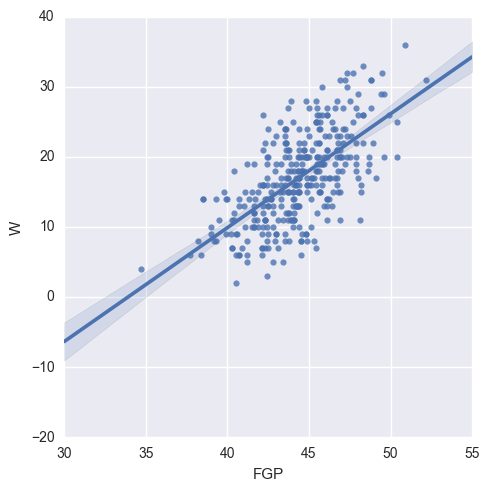

In [1352]:
sns.lmplot(data=df_cut, x='FGP', y='W',ci=95)

The scatterplot visualizes the predicted W value across FGP values. 

# Research Question #2: Is there a group of influential points when predicting team wins?

### Technique: Outlier Detection (4)

I used the FGP_model, which was determined to be the best model in my research question 1. In this model, I used the get_influence() method to calculate the cooks distance for each team. I created a plot of cooks distance on the y axis and index on the x axis. I plotted an h-line at 4/number of observations, which is known as the cooks threshold, to see if there were teams that had a cooks_distance greater than the threshold.

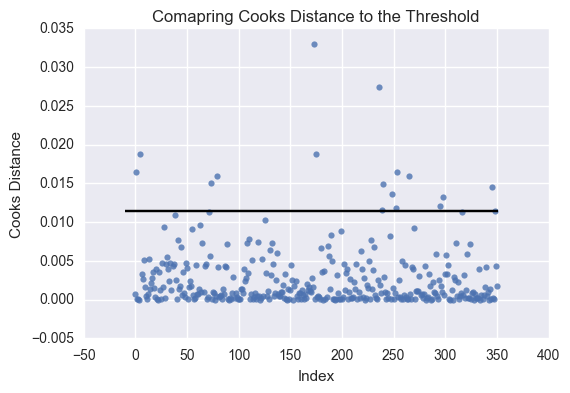

In [1331]:
influence = FGP_model.get_influence()
cooks_distance = influence.cooks_distance[0]
number_of_observations = len(df_cut)

ax = sns.regplot(np.arange(len(cooks_distance)),cooks_distance,ci=0,fit_reg=False)
plt.hlines(4/number_of_observations,-10,351,label='Threshold')
cooks_threshold = 4 / number_of_observations

plt.xlabel('Index');
plt.ylabel('Cooks Distance');
plt.title('Comapring Cooks Distance to the Threshold');

In the above output, it appears there is a significant amount of teams that have a cooks_distance value that exceeds the cooks_distance threshold.

I have created a new frame to plot the influence statistics of individual teams. I sorted this frame by cooks_d or cooks distance to determine which teams are the most infuential in our regression. Cooks distance gives a measure of how our model would would differ if that particular point was left out. 

In [913]:
infl1 = FGP_model.get_influence()
summaryF = infl1.summary_frame()
summaryF.sort_values('cooks_d',ascending=False).head(5)

,dfb_Intercept,dfb_FGP,cooks_d,dffits,dffits_internal,hat_diag,standard_resid,student_resid
Unnamed: 1,,,,,,,,
Gonzaga *,0.092641,0.240440,0.033013,0.257670,0.256954,0.022040,1.711626,1.716391
Massachusetts-Lowell,-0.131902,-0.195718,0.027454,-0.236016,-0.234327,0.009122,-2.442277,-2.459887
Oregon *,0.104946,0.164053,0.018811,0.194749,0.193965,0.009811,1.948622,1.956501
Utah,-0.074632,-0.178885,0.018736,-0.193829,-0.193575,0.019217,-1.382908,-1.384725
Morgan State,0.071673,-0.166807,0.016444,0.181553,0.181353,0.018281,1.328990,1.330456


In order to investigate the outliers, I have added three columns to look at how the predictor variable (FGP) and outcome variable(W) differed at high levels of cooks_d (Difference).

In [914]:
df_z = df_cut[:]
df_z.ix[:,:] = skp.scale(df_z.ix[:,:].astype(np.float))
summaryF['W'] = df_z['W']
summaryF['FGP'] = df_z['FGP'] 
summaryF['Differnce'] = df_z['W'] - df_z['FGP'] 
summaryF =summaryF.drop('hat_diag',axis=1)
summaryF.sort_values('cooks_d',ascending=False).head(10)

,dfb_Intercept,dfb_FGP,cooks_d,dffits,dffits_internal,standard_resid,student_resid,W,FGP,Differnce
Unnamed: 1,,,,,,,,,,
Gonzaga *,0.092641,0.240440,0.033013,0.257670,0.256954,1.711626,1.716391,2.962198,2.595399,0.366800
Massachusetts-Lowell,-0.131902,-0.195718,0.027454,-0.236016,-0.234327,-2.442277,-2.459887,-0.933095,1.483812,-2.416907
Oregon *,0.104946,0.164053,0.018811,0.194749,0.193965,1.948622,1.956501,2.494763,1.563211,0.931552
Utah,-0.074632,-0.178885,0.018736,-0.193829,-0.193575,-1.382908,-1.384725,0.469211,2.396901,-1.927690
Morgan State,0.071673,-0.166807,0.016444,0.181553,0.181353,1.328990,1.330456,-0.465660,-2.327342,1.861683
Jackson State,0.071673,-0.166807,0.016444,0.181553,0.181353,1.328990,1.330456,-0.465660,-2.327342,1.861683
South Carolina *,0.136501,-0.117180,0.015930,0.179899,0.178496,2.531113,2.551007,1.404081,-0.858460,2.262541
William & Mary,-0.083924,-0.157845,0.015913,-0.178768,-0.178401,-1.558904,-1.562117,0.001776,1.880807,-1.879032
Alabama A&M,-0.095000,0.145668,0.015030,-0.173908,-0.173378,-1.765900,-1.771299,-2.335400,-1.533352,-0.802049


Before seeing this output, I thought that at high cooks_d values, the W and FGP values would be drastically different. Meaning they would either have a high value for the predictor or the response, but not both. This does not appear to be true in all cases, as Gonzaga has high values for both W and FGP, thus little difference. However it does appear that teams, with similar values for both W and FGP; have high/low values for W. W is the outcome variable (Y-axis) in our regression. Therefore these points could be considered outliers. So after analyzing the high cooks-d points it appears they are either: significantly different in W and FGP values or have a extreme W value (greater than 2 z-score)

I will create a new dataset that filters out teams who have a cooks distance greater than the threshold. This is called clean_cut.

In [1353]:
outliers_cut = df_z[cooks_distance > cooks_threshold]
clean_cut = df_z[cooks_distance < cooks_threshold]
len(outliers_cut)

16

Now I will re-run the FGP regression excluding the teams who have a cooks distnace greater than the threshold.

In [1354]:
clean_FGP = smf.ols('W ~ FGP', data=clean_cut).fit()
clean_FGP.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      W   R-squared:                       0.412
Model:                            OLS   Adj. R-squared:                  0.411
Method:                 Least Squares   F-statistic:                     233.7
Date:                Tue, 18 Apr 2017   Prob (F-statistic):           2.46e-40
Time:                        20:29:42   Log-Likelihood:                -367.60
No. Observations:                 335   AIC:                             739.2
Df Residuals:                     333   BIC:                             746.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.0166      0.040     -0.418      0.676        -0.095     0.062
FGP            0.6385      0.042     15.286      0.000         0.556     0.721
==============================================================================
Omnibus:                        2.844   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.246
Skew:                           0.053   Prob(JB):                        0.325
Kurtosis:                       2.613   Cond. No.                         1.06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The R squared value shows that filtering out this data only provide a marginal improvement. As the R-squared value increases by .006, compared to the regression with the full data set. 

# Research Question #3: Do certain clusters of teams perform significantly better than other clusters? How many clusters are optimal?

### Technique: Clustering (5)

Creating a new filtered DataFrame that only contains teams that Qualify for the NCAA tournament called march.

In [971]:
march = df_new[df_new.Qualify==1]
march.head(5)

School,G,W,L,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,...,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Qualify
Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
Princeton *,30,23,7,0.767,6.59,-1.83,71.633333,61.433333,25.733333,57.200000,...,13.866667,0.738,8.200000,33.433333,14.200000,6.666667,3.100000,9.933333,16.066667,1
Florida *,36,27,9,0.750,22.41,11.02,77.888889,66.500000,26.472222,58.833333,...,23.638889,0.729,11.194444,36.972222,12.500000,7.555556,4.638889,12.000000,18.361111,1
Arizona *,37,32,5,0.865,18.25,7.63,76.567568,65.945946,26.405405,55.351351,...,22.432432,0.765,10.243243,36.702703,13.540541,5.432432,3.216216,11.189189,16.891892,1
Notre Dame *,36,26,10,0.722,17.82,9.79,77.305556,69.277778,27.222222,59.416667,...,16.972222,0.800,9.083333,33.666667,15.722222,7.083333,3.722222,9.500000,14.805556,1
Winthrop *,33,26,7,0.788,1.36,-6.10,79.242424,70.363636,27.000000,59.303030,...,21.969697,0.717,9.545455,37.090909,12.818182,6.545455,5.121212,13.030303,18.333333,1


I have created a new Dataframe called top 15, which features the top teams that Qualified for the tournament sorted on W-L%.

In [1084]:
top15 = march.sort_values('W-L%',ascending=False)[:15]

Before fitting my K-means model, I want to run a Silohuette Model to determine the most optimal number of clusters on the top15 data Frame

For n_clusters = 2 The average silhouette_score is : 0.266947258312


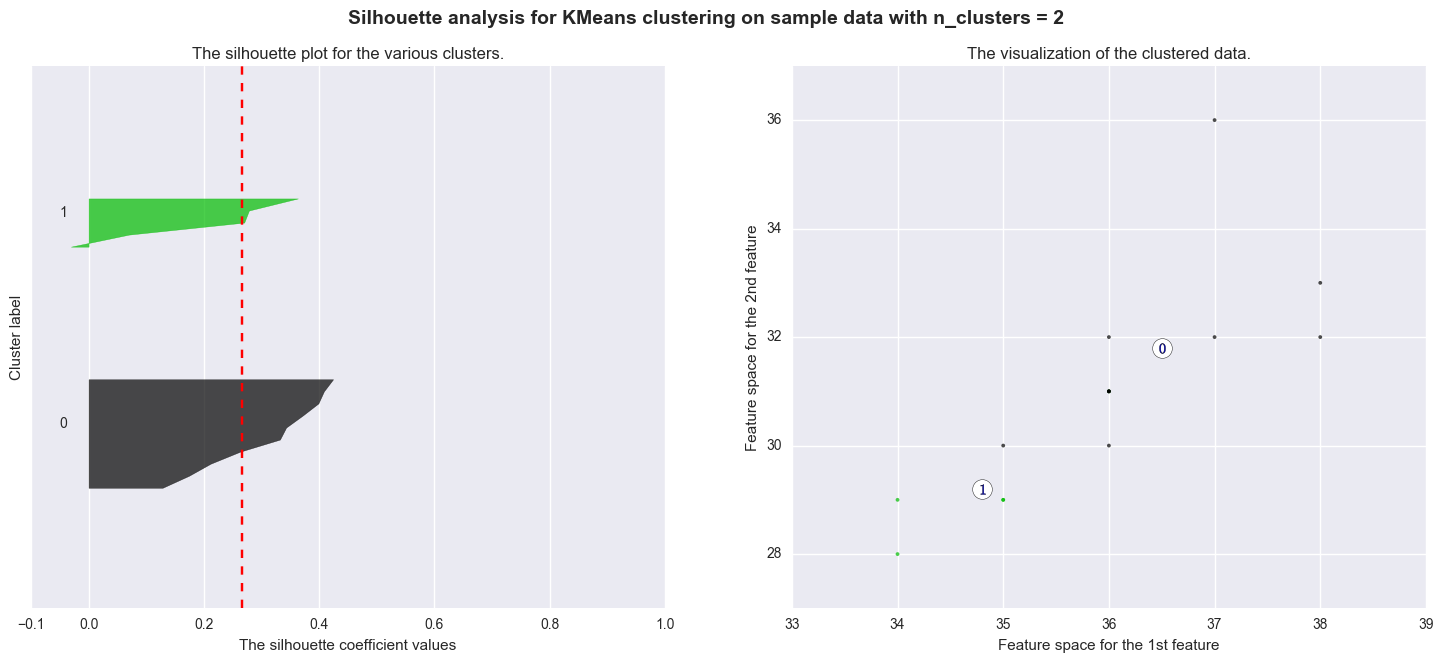

For n_clusters = 3 The average silhouette_score is : 0.288748789549


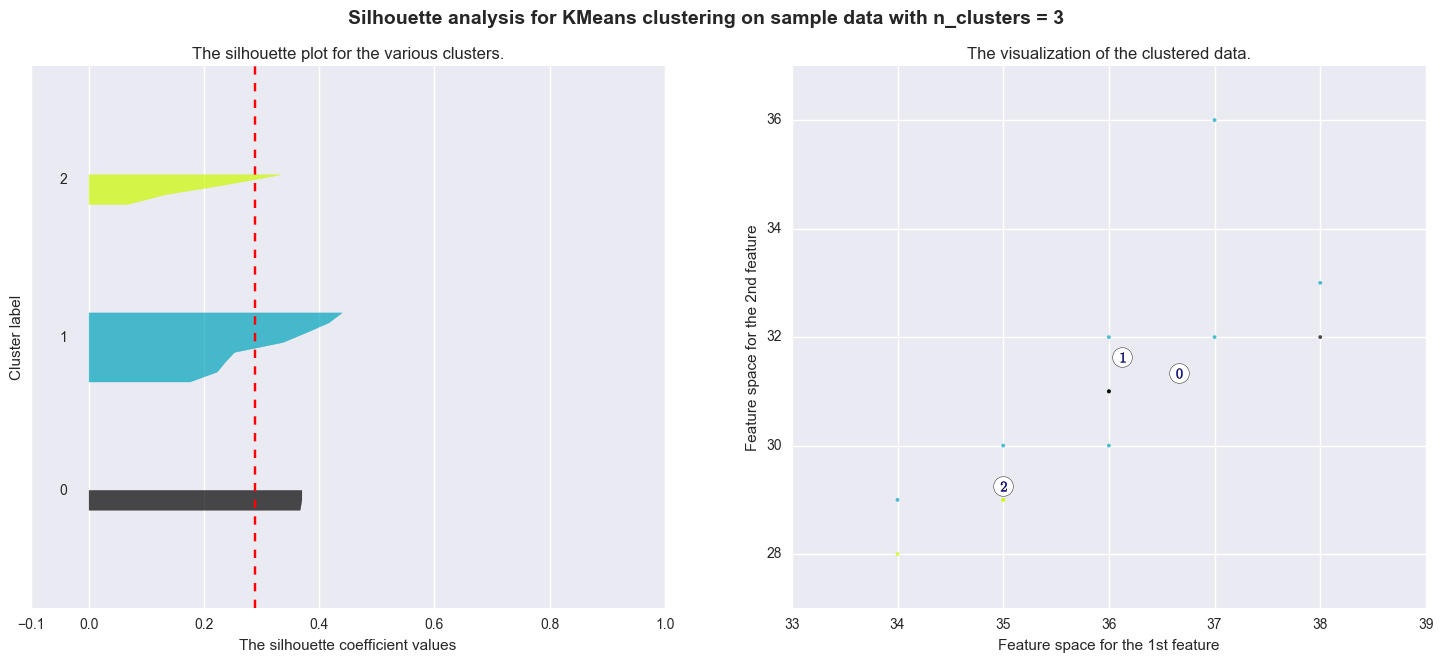

For n_clusters = 4 The average silhouette_score is : 0.271338763478


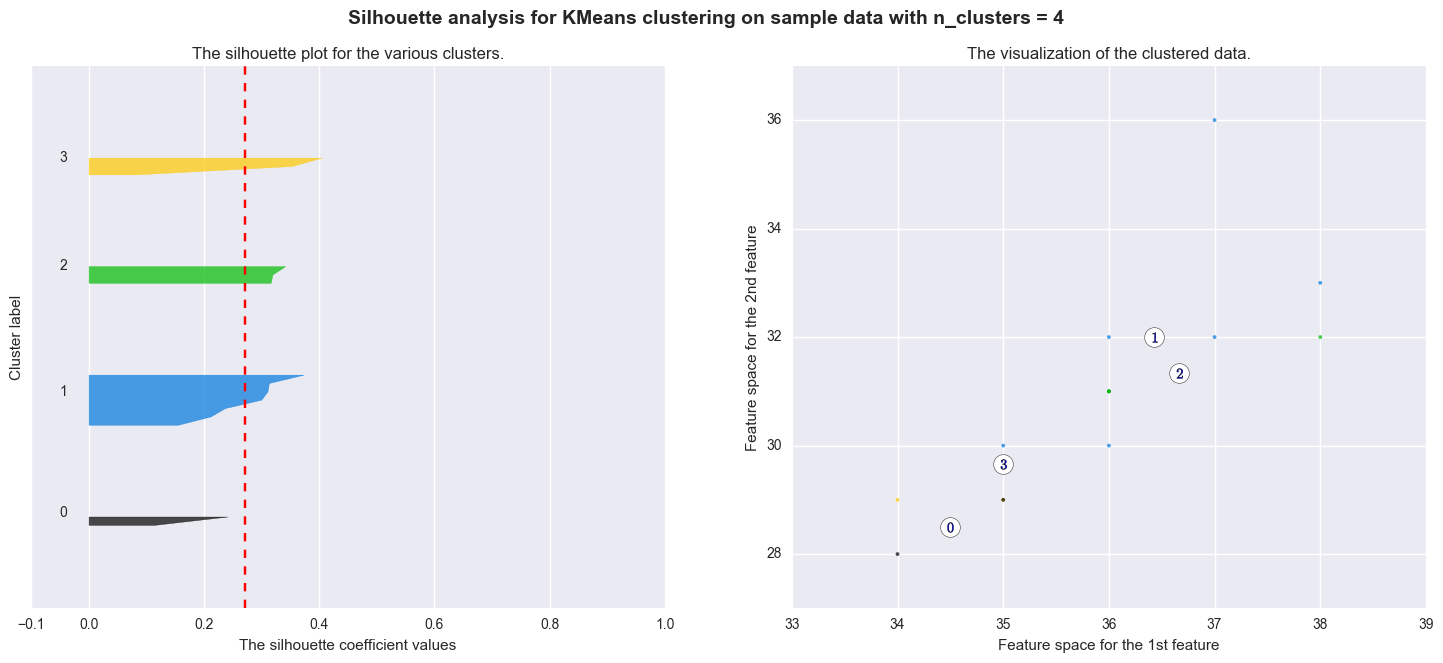

For n_clusters = 5 The average silhouette_score is : 0.23855957117


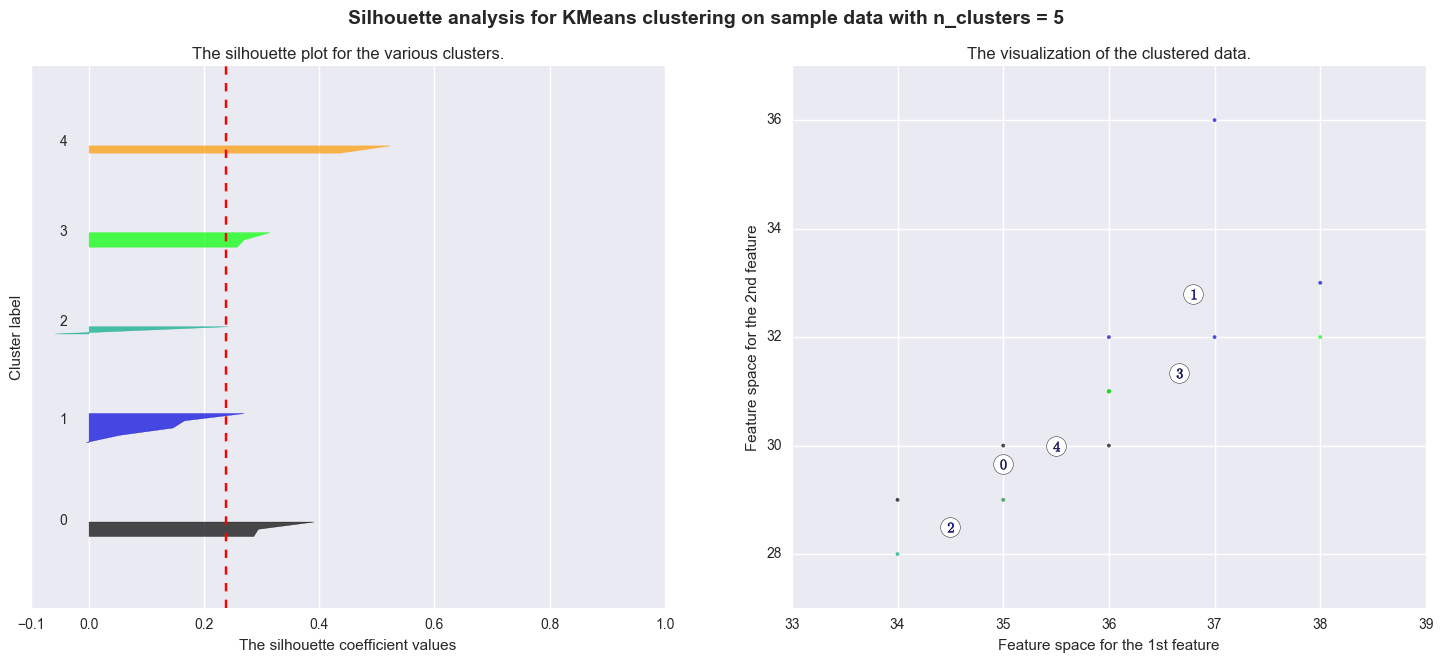

For n_clusters = 6 The average silhouette_score is : 0.211292146346


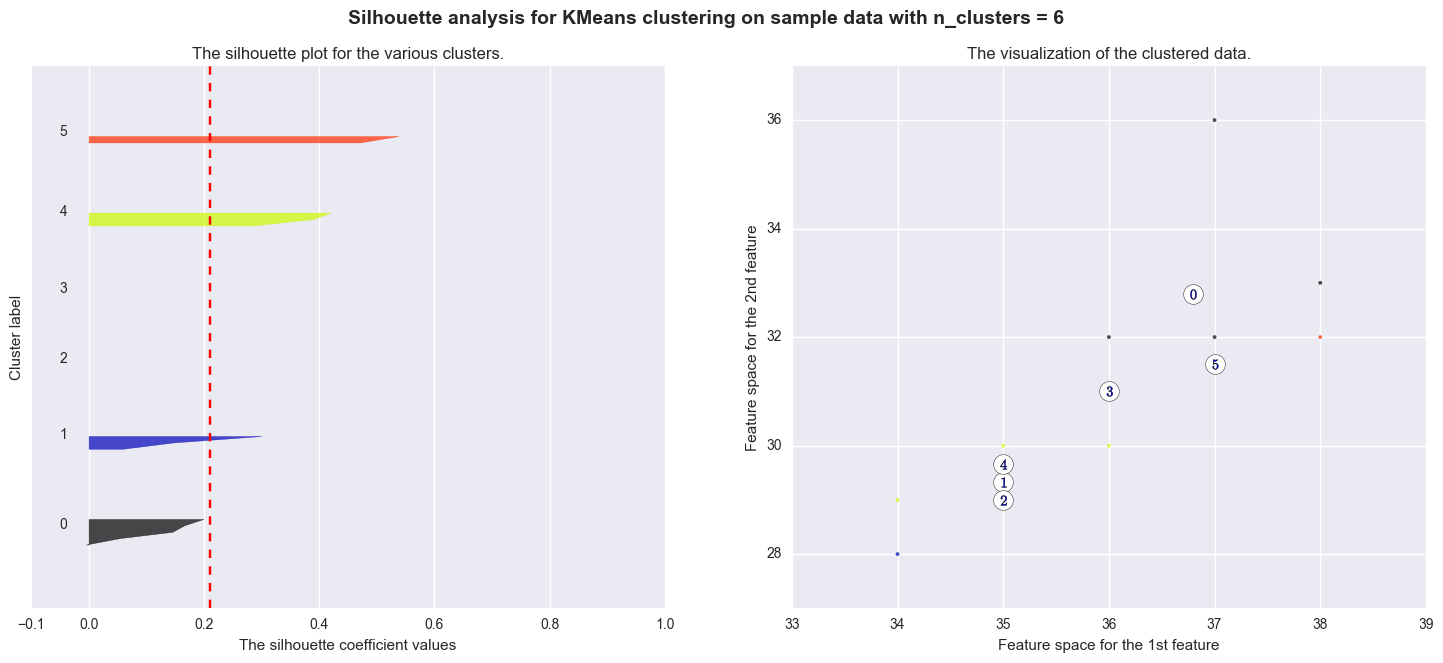

In [1093]:
def plotSilhouette(march,range_n_clusters=[2, 3, 4, 5, 6]):
    X = march.as_matrix()

    for n_clusters in range_n_clusters:
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(18, 7)
        ax1.set_xlim([-0.1, 1])
        ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
        clusterer = KMeans(n_clusters=n_clusters, random_state=10)
        cluster_labels = clusterer.fit_predict(X)
        silhouette_avg = skmetric.silhouette_score(X, cluster_labels)
        print("For n_clusters =", n_clusters,
              "The average silhouette_score is :", silhouette_avg)
        sample_silhouette_values = skmetric.silhouette_samples(X, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # Label the silhouette plots with their cluster numbers at the middle
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # Compute the new y_lower for next plot
            y_lower = y_upper + 10  # 10 for the 0 samples

        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # The vertical line for average silhouette score of all the values
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # Clear the yaxis labels / ticks
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 2nd Plot showing the actual clusters formed
        colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors)

        # Labeling the clusters
        centers = clusterer.cluster_centers_
        # Draw white circles at cluster centers
        ax2.scatter(centers[:, 0], centers[:, 1],
                    marker='o', c="white", alpha=1, s=200)

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')

        plt.show()
plotSilhouette(top15)

Below I am plotting the Silohuette Score for each cluster number to see which number of clusters results in the greatest silohuette score.

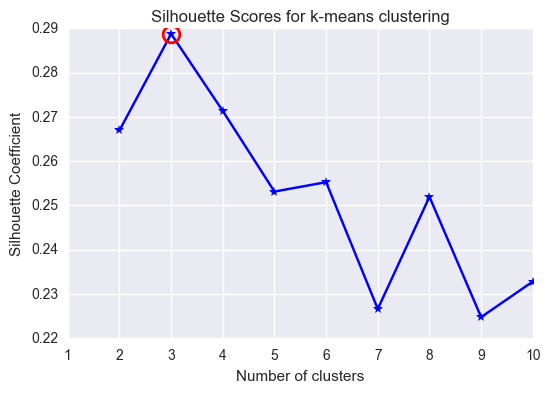

In [1097]:
X = top15.copy()  # Using the the dataset of Section 1
K = range(2,11)  # Apply kmeans 2 to 10

# run k-means for each k
KM = [skc.KMeans(n_clusters=k).fit(X) for k in K]

# Note that silhouette_score is unhappy with k=1
# calculate the silhouette for each model
silh_scores = [skm.silhouette_score(X,km.labels_) for km in KM]

# find the best score
kIdx = np.argmax(silh_scores)


plt.plot(K, silh_scores, 'b*-')
plt.plot(K[kIdx], silh_scores[kIdx], marker='o', markersize=12, 
         markeredgewidth=2, markeredgecolor='r', markerfacecolor='None')
plt.xlim(1, plt.xlim()[1])
plt.xlabel('Number of clusters');
plt.ylabel('Silhouette Coefficient');
plt.title('Silhouette Scores for k-means clustering');

In the output above it is apparent that 3 clusters produces the highest silohutte coefficent, therefore this is waht I wil use in my model.

Below I generated an elbow plot to test the amount of explained varaince with each cluster. It is difficult to determine where the "elbow' is in this plot. However it appears to be about 3 clusters

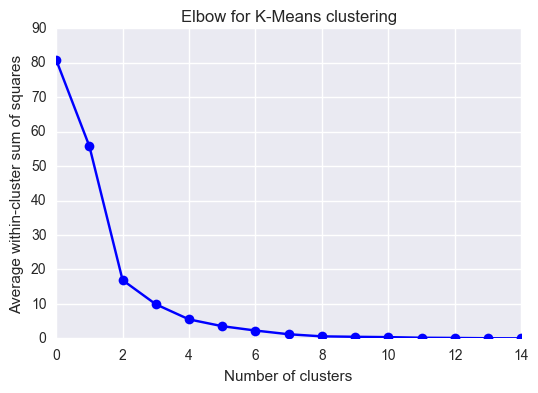

In [1355]:
pca_model = skd.PCA().fit(top15.ix[:,:])
len(pca_model.explained_variance_)
plt.plot(range(0,15),pca_model.explained_variance_,'b-o')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

Below I have fit the K-means model with the number of clusters indicated by the Silohutte plot, 3. I have also specified 2 components becuase I am using an X and Y coordinate.

In [1100]:
coords = skma.MDS(n_components=2).fit_transform(top15)
x = [d[0] for d in coords]
y = [d[1] for d in coords]


df_km = top15.copy()
kmeans_model = skc.KMeans(3).fit(df_km)
#kmeans_model.fit(top15.ix[:,:])
df_km['x'] = x
df_km['y'] = y
df_km['cluster_label'] = kmeans_model.labels_

I am now plotting each team in the top_15 Data Frame based on their x,y coordiantes and the cluster they fall into. 

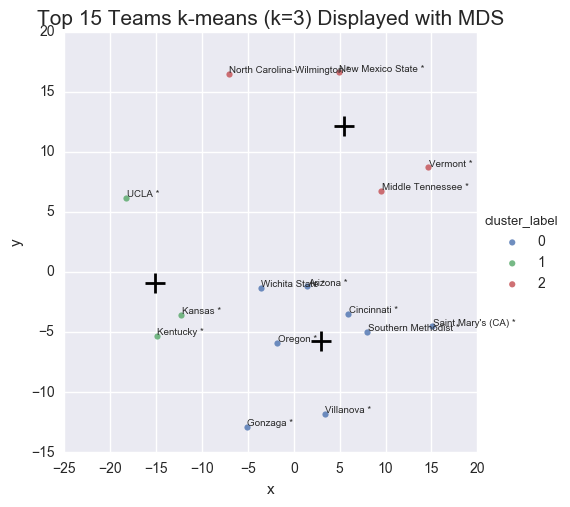

In [1108]:
centroids_mds = df_km.groupby("cluster_label").mean()[['x',
                                                               'y']].as_matrix()

f = sns.lmplot(x='x', y='y', data=df_km, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('Top 15 Teams k-means (k=3) Displayed with MDS', 
          fontsize=15);


teams = [x for x in top15.index]
#Annotating each point with the team name 
for i, teams in enumerate(teams):
    plt.annotate(teams, (x[i]+0.05, y[i]+0.07), 
                 fontsize=7)

This cell features filters for each of the clusters shown in the K-mean output above

In [1356]:
#df_km[df_km.cluster_label==2].index
#df_km[df_km.cluster_label==1].index
df_km[df_km.cluster_label==0]

School,G,W,L,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,...,TRB,AST,STL,BLK,TOV,PF,Qualify,x,y,cluster_label
Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
Gonzaga *,37,36,1,0.973,25.57,3.25,83.243243,60.918919,29.729730,58.405405,...,40.459459,15.378378,7.027027,4.594595,11.378378,16.675676,1,-5.110687,-12.888345,0
Villanova *,36,32,4,0.889,23.81,9.29,77.194444,62.666667,26.805556,54.111111,...,33.555556,14.027778,7.194444,3.027778,11.166667,14.305556,1,3.397089,-11.803140,0
Oregon *,38,33,5,0.868,20.71,7.93,78.947368,65.473684,28.131579,58.210526,...,36.526316,15.973684,6.526316,6.342105,11.526316,15.631579,1,-1.775756,-5.868791,0
Arizona *,37,32,5,0.865,18.25,7.63,76.567568,65.945946,26.405405,55.351351,...,36.702703,13.540541,5.432432,3.216216,11.189189,16.891892,1,1.485605,-1.179972,0
Wichita State *,36,31,5,0.861,21.24,2.96,81.000000,62.388889,27.555556,58.722222,...,40.888889,16.277778,6.527778,3.888889,11.277778,18.777778,1,-3.605572,-1.327200,0
Southern Methodist *,35,30,5,0.857,18.72,4.46,74.257143,60.000000,26.114286,55.257143,...,38.142857,16.171429,5.714286,3.342857,10.771429,14.457143,1,8.026557,-4.950892,0
Saint Mary's (CA) *,34,29,5,0.853,16.80,2.24,72.029412,57.470588,26.235294,52.852941,...,35.441176,16.558824,4.205882,3.235294,10.735294,15.058824,1,15.076151,-4.503327,0
Cincinnati *,36,30,6,0.833,18.44,5.50,74.277778,61.333333,26.916667,58.777778,...,36.888889,15.472222,7.250000,4.805556,10.111111,15.722222,1,5.924153,-3.454719,0


## Technique: Classification (6)

### Decsion Tree (Not Included in Final Report)

I am creating a new Data Frame called frame. I will split this Data Frame into both a train and test set. Where roughly 70% of teams in the df_new dataset will be included in the train set and 30% will be in the test_set.

In [1357]:
frame = df_new.copy()

msk = np.random.rand(len(frame)) < .7
frame_train = frame[msk]
#len(frame_train)
frame_test = frame[~msk]
#en(frame_train)

In the code below, I am varying the depth of the decision tree (from 1 to 10) and calculate the accuracy at the different levels.

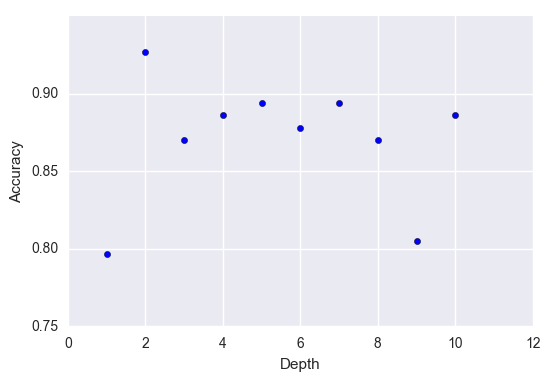

In [1233]:
x= []
y = []
outcome= pd.DataFrame() 

for i in range(1,11):
    dt_model = sktree.DecisionTreeClassifier(max_depth=i,criterion='entropy')
    dt_model.fit(frame_train.ix[:,:-1],frame_train['Qualify'])
    y_pred= dt_model.predict(frame_test.ix[:,:-1])
    outcome['predicted_dt_tree'] = y_pred
    x.append(i)
    y.append(skm.accuracy_score(y_true= frame_test['Qualify'],y_pred=outcome['predicted_dt_tree']))

plt.scatter(x,y)
plt.xlabel('Depth')
plt.ylabel('Accuracy')  #the model overfits to the train set

The output above shows that the depth of 2 results in the greatest accuracy,beyond this depth, the accuracy appears to decrease. This is likely becuase beyond this depth the model is overfitting to the training data and therefore is less accurate in predicting if a team will qualify.  Therefore this is the max_depth I specified in my decsion tree model. 

I have specified a DecisonTree Classifier below using a max_depth of 2 and a criterion of entropy. I have fit the model using the frame_train Data Frame, then generated predictions using the frame_test Data Frame. I am using all columns besides "Qualify" to predict if a team will Qualify for the NCAA tournament.

In [1234]:
frame = df_new.copy()
## Build and train the classifier
dt_model = sktree.DecisionTreeClassifier(max_depth=2,
                                         criterion='entropy')
# given first 4 columns, learn the species
dt_model.fit(frame_train.ix[:,:-1],frame_train['Qualify'])


y_pred= dt_model.predict(frame_test.ix[:,:-1])
frame_test['predicted_dt_tree'] = y_pred

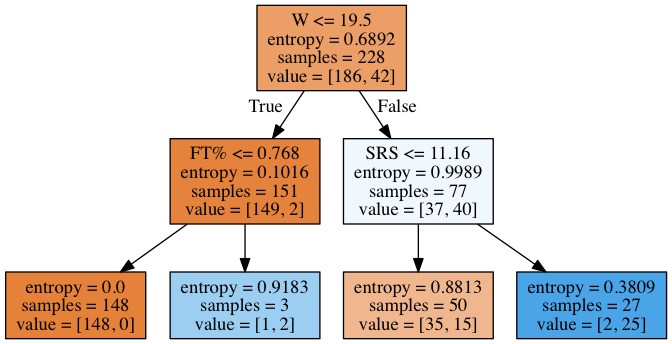

In [1237]:
dot_data = sksix.StringIO()
sktree.export_graphviz(dt_model, out_file=dot_data,
                       feature_names=df_new.columns[:-1],
                       filled=True)
graph = pydot.graph_from_dot_data(dot_data.getvalue())
ipd.Image(graph.create_png())

In the decision tree we can see, W is an important predictor for determining if a team will Qualify for the tournament. For example, if a team has a W value greater than 19.5 and a SRS value greater than 11.16. It is almost certain they will Qualify for the tournament, as 25 out of 27 teams that met these condtions, qualified for the tournament. On the other hand if a team has an W value, less than 19.5 and had a FT% less than .768. It is almost certain they will not qualify as 148 out of the 148 teams that met these conditions, did not qualify.  

In [1236]:
skm.accuracy_score(y_true= frame_test['Qualify'],y_pred=frame_test['predicted_dt_tree'])

0.92682926829268297

This decision tree model has an accuracy of roughly 92% accuracy. 

## Research Question #4: What are the most important features for classifying a team as Qualified/Not Qualified? How accurately can we classify teams?

Creating a new DataFrame that removes the Games, Wins, and Losses columns becuase I believe W-L% can represent this information. Therefore I chose to only include W-L% to get a appropriate representation of the importance of winning in the feature importance graph.

In [1390]:
rf = pd.DataFrame(df_new)
rf.drop(df_new.columns[0:3], axis=1, inplace=True)
rf.head()

School,W-L%,SRS,SOS,Total Points,Opponent Points,FG,FGA,FG%,3P,3PA,...,FTA,FT%,ORB,TRB,AST,STL,BLK,TOV,PF,Qualify
Unnamed: 1,,,,,,,,,,,,,,,,,,,,,
Charlotte,0.433,-5.22,-0.91,76.500000,80.233333,26.666667,60.100000,0.444,7.900000,21.000000,...,20.466667,0.746,7.466667,32.633333,12.033333,6.333333,3.133333,12.200000,19.266667,0
Purdue *,0.771,20.14,8.80,79.714286,68.371429,28.000000,58.400000,0.479,9.000000,22.342857,...,19.428571,0.757,9.714286,37.771429,18.285714,5.171429,2.485714,12.971429,15.771429,1
Pacific,0.333,-4.53,2.13,66.848485,71.848485,23.757576,58.757576,0.404,5.606061,16.969697,...,20.333333,0.675,11.606061,37.121212,12.000000,4.242424,1.909091,11.696970,20.909091,0
Troy *,0.595,-0.42,-3.31,78.081081,72.081081,26.540541,58.189189,0.456,8.405405,23.432432,...,22.891892,0.725,10.891892,36.810811,13.081081,5.972973,3.486486,12.486486,17.675676,1
Maryland-Baltimore County,0.618,-3.83,-5.86,81.147059,77.176471,28.147059,60.029412,0.469,9.705882,24.705882,...,20.323529,0.745,8.823529,35.264706,14.911765,6.588235,2.352941,12.088235,18.382353,0


I am fitting a Random Forest model on the rf Dataframe. In which I am trying to classify teams as Qualified or Unqualified for the NCAA tournament based on their values across the other columns in the DataFrame. I have used 100 n_estiamtors, in order to aggregate many decsion trees into my random forest.

In [1391]:
import sklearn.ensemble as skens
rf_model = skens.RandomForestClassifier(n_estimators=100)
rf_model.fit(rf.ix[:,:'PF'],rf.Qualify)
predicted_labels = rf_model.predict(rf.ix[:,:'PF'])
rf['predicted_rf_tree'] = predicted_labels

In [1392]:
skmetric.accuracy_score(y_true=df_new["Qualify"],
                       y_pred=rf["predicted_rf_tree"])

1.0

The results show that this model was predicting a team’s qualification with 100% accuracy. This seems too high, the model is likely overfitting becuase currently the model is being tested on the same data that it is being trained on.

To mitigate this problem, I created a train/test split of my data.  Where roughly 70% of teams in the df_new dataset will be included in the train set and 30% will be in the test_set.

In [1393]:
mask = np.random.rand(len(rf)) < .7

rf_train = rf[mask]
rf_test = rf[~mask]

Using this new split, I re-trained/tested my Random Forest classifier to produce more robust results. 

In [1394]:
rf_model = skens.RandomForestClassifier(n_estimators=100)
rf_model.fit(rf_train.loc[:,:'PF'],rf_train.Qualify)
predicted_labels = rf_model.predict(rf_test.loc[:,:'PF'])
rf_test['predicted_rf_tree'] = predicted_labels


/Applications/anaconda/envs/si370/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [1395]:
skmetric.accuracy_score(y_true=rf_test["Qualify"],
                       y_pred=rf_test["predicted_rf_tree"])

0.9285714285714286

This model is predicting with roughly 92.4% accuracy. May vary based on the train/test split

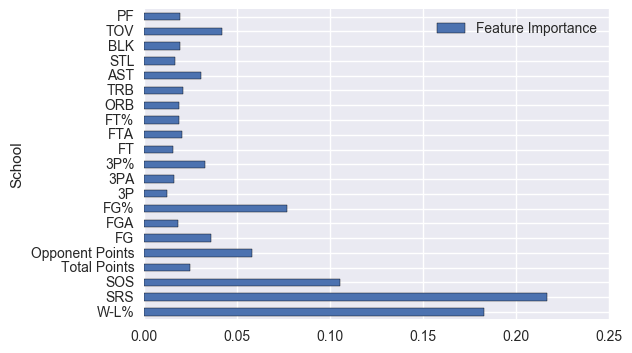

In [1396]:
feat_importance = rf_model.feature_importances_
pd.DataFrame({'Feature Importance':feat_importance},
            index=rf_test.columns[:-2]).plot(kind='barh')

The Feature Importance graph provides us with a measure of the importance of each feature in the random forest model. Based on the results, we can see the most important features in our random forest model are: Win/Loss percentage, SRS (Simple Rating System), SOS (Strength of Schedule), FG% (Field Goal Percentage), and Opponent Points. 

May vary based on the train/test split